In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""   Analyse simulations   -- Version 1.1
Last edit:  2023/06/12
Authors:    Leone, Riccardo (RL)
Notes:      - Evaluate the different combinations of b and w
            - Release notes:
                * 
To do:      - 
Comments:   

Sources: 
"""

'   Analyse simulations   -- Version 1.1\nLast edit:  2023/06/12\nAuthors:    Leone, Riccardo (RL)\nNotes:      - Evaluate the different combinations of b and w\n            - Release notes:\n                * \nTo do:      - \nComments:   \n\nSources: \n'

## Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from petTOAD_setup import *

Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


## Imports

In [5]:
EXPL_DIR = RES_DIR / "exploratory_ws_-0.5-0.5_bs_-0.05-0.05"
EXPL_FIG_DIR = EXPL_DIR / "Figures"
if not Path.exists(EXPL_FIG_DIR):
    Path.mkdir(EXPL_FIG_DIR)
MCI_DIR = RES_DIR / "model_simulations" / "MCI_noWMH"

## Define useful functions

In [6]:
def annotate_star(tbl):
    """
    This function is just to plot a start at the best heatmap value for better recognition    
    """
    star = tbl.where(tbl == tbl.values.max())
    star = star.replace({np.nan: ""})
    star = star.replace({tbl.values.max(): '*'})
    return star

def save_plot_results(res_df, group):
    """
    This function starts from the results dataframe, converts it into a pivot-table, which is what seaborn need to plot the heatmap.
    It does so both for fc and for phfcd. Also plots and saves the results.
    """
    # Convert the result df into a pivot table so to plot heatmap
    table_fc = pd.pivot_table(res_df, values='fc_pearson', index='b', columns='w').astype(float)
    # Skip fcd for now
    #table_fcd = pd.pivot_table(res_df, values='fcd_ks', index='b', columns='w').astype(float)
    table_phfcd = pd.pivot_table(res_df, values='phfcd_ks', index='b', columns='w').astype(float)
    # Create a composite score by summing up the single model fits so to choose when FC and phFCD have different "best" b-w combinations
    table_sum = table_fc + table_phfcd

    # Create Heatmaps
    fig, axs = plt.subplots(1,3, figsize = (15,5))
    sns.heatmap(ax = axs[0],
                data = table_fc,
                annot = annotate_star(table_fc),
                fmt = '', 
                annot_kws={"size": 10})
    axs[0].set_title(f"FC {group}")

    #Still skip fcd for now
    # sns.heatmap(ax = axs[0,1],
    #             data = table_fcd,
    #             annot = annotate_star(table_fcd),
    #             fmt = '', 
    #             annot_kws={"size": 10})
    # axs[0,1].set_title(f"FCD {group}")

    sns.heatmap(ax = axs[1],
                data = table_phfcd, 
                annot = annotate_star(table_phfcd),
                fmt = '', 
                annot_kws={"size": 10})
    axs[1].set_title(f"1 - phFCD {group}")
    sns.heatmap(ax = axs[2],
                data = table_sum, 
                annot = annotate_star(table_sum),
                fmt = '', 
                annot_kws={"size": 10})
    axs[2].set_title(f"FC + (1 - phFCD) {group}")
    plt.savefig(EXPL_DIR / f"{group}_results_heatmap.png")

def perform_group_analyses(adnimerge, big_df, group):
    """
    This function allow us to select the grouping classification (Fazekas 1 or 2) as the 'group'variable  and it selects 
    only hc and mci with wmh based on the chosen classification (since we are not interested for this type of model in patients without WMH)
    """
    
    HC_WMH = adnimerge[adnimerge[group] == 'CN_WMH']['PTID']
    MCI_WMH = adnimerge[adnimerge[group] == 'MCI_WMH']['PTID']

    #HC_no_WMH = adnimerge[adnimerge[group] == 'CN_no_WMH']['PTID']
    # hc_no_wmh_df = big_df[big_df['PTID'].isin(HC_no_WMH)]
    # hc_no_wmh_grouped = hc_no_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    # save_plot_results(hc_no_wmh_grouped, "hc_no_wmh_Fazekas_1.0")

    hc_wmh_df = big_df[big_df['PTID'].isin(HC_WMH)]
    hc_wmh_grouped = hc_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    save_plot_results(hc_wmh_grouped, f"hc_wmh_{group}")

    #MCI_no_WMH = adnimerge[adnimerge[group] == 'MCI_no_WMH']['PTID']
    # mci_no_wmh_df = big_df[big_df['PTID'].isin(MCI_no_WMH)]
    # mci_no_wmh_grouped = mci_no_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    # save_plot_results(mci_no_wmh_grouped, "mci_no_wmh_Fazekas_1.0")

    mci_wmh_df = big_df[big_df['PTID'].isin(MCI_WMH)]
    mci_wmh_grouped = mci_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    save_plot_results(mci_wmh_grouped, f"mci_wmh_{group}")


## Prepare data

In [7]:
# Same reduced list as the exploratory simulations
short_subjs = HC_WMH[:30]
short_subjs = np.append(short_subjs, HC_no_WMH[:30])
short_subjs = np.append(short_subjs, MCI_no_WMH[:30])
short_subjs = np.append(short_subjs, MCI_WMH[:30])
# Load wmh dictionary
wmh_dict = get_wmh_load_homogeneous(short_subjs)
# Create a overall df and populate it with single subject results
big_df = pd.DataFrame()

# We loop through every subject
for subj in short_subjs:
    # we read the csv of saved results
    res_df = pd.read_csv(EXPL_DIR / f"sub-{subj}_df_results_initial_exploration_wmh.csv", index_col=0)
    res_df['PTID'] = subj
    res_df['wmh_load'] = wmh_dict[subj]
    # we concatenate results of all subjects
    big_df = pd.concat([big_df, res_df], ignore_index=True)
# Then, let's work with 1-phfcd so to have higher numbers = better fits
#big_df['fcd_ks'] = 1 - big_df['fcd_ks']
big_df['phfcd_ks'] = 1 - big_df['phfcd_ks']
# Get the best model fits for fc, phfcd for each subject and create one single df (skip fcd for now)
res_df_best = pd.DataFrame({'fc_pearson' : big_df.groupby(["PTID"])["fc_pearson"].max(),
                            'phfcd_ks' : big_df.groupby(["PTID"])["phfcd_ks"].max()}).reset_index()

res_df_best["wmh_load"] = [wmh_dict[subj] for subj in res_df_best['PTID']]

# This df is to check what are the best w, b in case of the best fc and best phfcd
max_fc_vals = big_df.groupby(["PTID"])['fc_pearson'].max().reset_index()
merged_df_max_fc = pd.merge(big_df, max_fc_vals, on = ['PTID', 'fc_pearson'])
max_phfcd_vals = big_df.groupby(["PTID"])['phfcd_ks'].max().reset_index()
merged_df_max_phfcd = pd.merge(big_df, max_phfcd_vals, on = ['PTID', 'phfcd_ks'])


# load the clinical dataframe with the groupings
adnimerge = pd.read_csv(RES_DIR / "petTOAD_dataframe.csv")
adnimerge["PTID"] = adnimerge["PTID"].str.replace("_", "")
big_df = big_df.rename(columns={'PTID': 'PTID'})
adnimerge = adnimerge.rename(columns={'Group_bin_Fazekas': 'Group_Fazekas_2.0'})
adnimerge["Group_Fazekas_1.0"] = np.where(
    adnimerge["Fazekas_periventricular"] + adnimerge["Fazekas_lobar"] < 2,
    adnimerge["Group_bin"] + "_no_WMH",
    adnimerge["Group_bin"] + "_WMH",
)

The values of b and w were chosen as:

- ws = np.linspace(-0.5, 0.5, 21)
- bs = np.linspace(-0.05, 0.05, 5)
the a was fitted as:
- a = -0.02 + w*WMH + b
- WMH range from 0 to 1

In [29]:
ws_ex = np.linspace(-0.1, 0.1, 21)
bs_ex = np.linspace(-0.025, 0.025, 5)
a_ex_0 = [-0.02 + w*0 + b for w in ws_ex for b in bs_ex]
a_ex_1 = [-0.02 + w*1 + b for w in ws_ex for b in bs_ex]
a_ex_med = [-0.02 + w*0.1 + b for w in ws_ex for b in bs_ex]
print("Range for a_s if WMH close to 0:")
print(round(np.array(a_ex_0).min(),3), round(np.array(a_ex_0).max(), 3))
print("Range for a_s if WMH close to 1 (not many are close to 1):")
print(round(np.array(a_ex_1).min(),3), round(np.array(a_ex_1).max(),3))
print("Range for a_s if WMH close to medium values:")
print(round(np.array(a_ex_med).min(),3), round(np.array(a_ex_med).max(),3))

Range for a_s if WMH close to 0:
-0.045 0.005
Range for a_s if WMH close to 1 (not many are close to 1):
-0.145 0.105
Range for a_s if WMH close to medium values:
-0.055 0.015


First, we want to check that:
1. The model is working as expected, so we plot the best possible fc and best possible phfcd for each subject:
2. If there is any relationship between the best achievable fc and phfcd and the wmh load (for example, does the model completely derange when there are a lot of WMH?)

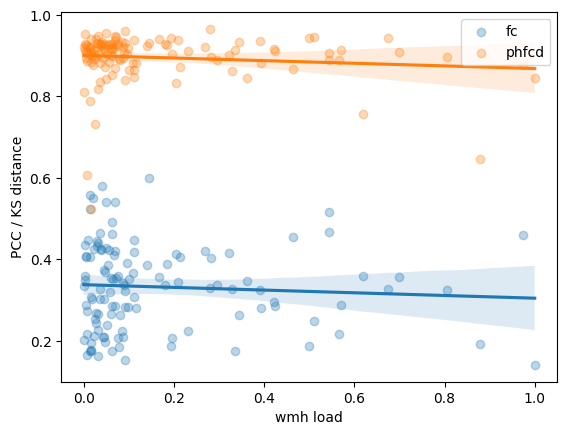

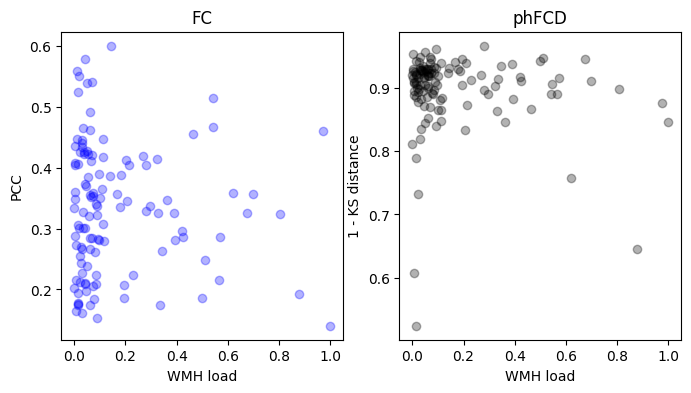

In [9]:
# Plot relationship between best model fits and wmh load 
# Here, all together, with regression
plt.figure()
ax1 = sns.regplot(res_df_best, y = 'fc_pearson', x = 'wmh_load', order = 1, scatter_kws={'alpha':0.3}, label = 'fc')
#ax2 = sns.regplot(res_df_best, y = 'fcd_ks', x = 'wmh_load', order = 2, scatter_kws={'alpha':0.3}, label = 'fcd')
ax3 = sns.regplot(res_df_best, y = 'phfcd_ks', x = 'wmh_load', order = 1, scatter_kws={'alpha':0.3}, label = 'phfcd')
ax3.set(ylabel = 'PCC / KS distance', xlabel = 'wmh load')
plt.legend()
plt.show()
plt.savefig(EXPL_FIG_DIR / "summary_best_values_regression.png")
plt.close()
# Here, separate, only with points
fig, axs = plt.subplots(ncols= 2, nrows = 1, figsize = (8, 4))
axs[0].plot(res_df_best['wmh_load'], res_df_best['fc_pearson'], 'bo', alpha = 0.3)
axs[0].set_ylabel('PCC')
axs[0].set_xlabel('WMH load')
axs[0].set_title('FC')
# axs[1].plot(res_df_best['wmh_load'], res_df_best['fcd_ks'], 'go', alpha = 0.3)
# axs[1].set_ylabel('1 - KS distance')
# axs[1].set_title('FCD')
axs[1].plot(res_df_best['wmh_load'], res_df_best['phfcd_ks'], 'ko', alpha = 0.3)
axs[1].set_ylabel('1 - KS distance')
axs[1].set_xlabel('WMH load')
axs[1].set_title('phFCD')
plt.savefig(EXPL_FIG_DIR / "summary_best_values_points.png")


It seems that for the vast majority of patients the best achievable fc and phfcd are high, as expected... there might be 2 patients for whom the empirical data might be corrupted or the model fails with the chosen parameters, but overall it seems that we can achieve fairly good fits. Also, from the regression lines, it seems that we can achieve the same maximum fit independently of the wmh load.

Now we ask ourselves, what are the values of a (obtained from the given combination of best w and best b) that give the best results? 

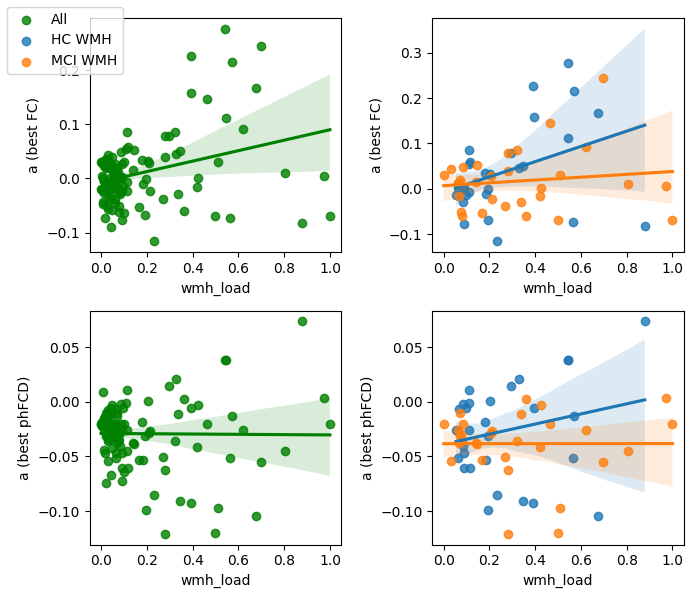

In [10]:
#Calculate the best a from the best w and the best b
merged_df_max_fc['a'] = -0.02 + merged_df_max_fc['w'] * merged_df_max_fc['wmh_load'] + merged_df_max_fc['b']
merged_df_max_phfcd['a'] = -0.02 + merged_df_max_phfcd['w'] * merged_df_max_phfcd['wmh_load'] + merged_df_max_phfcd['b']
# Plot 
fig, axs = plt.subplots(2, 2, figsize = (7,6))
# Values that give the best FC
sns.regplot(ax=axs[0,0], data=merged_df_max_fc, x = 'wmh_load', y = 'a', color='green', label = 'All')
sns.regplot(ax=axs[0,1], data=merged_df_max_fc[merged_df_max_fc['PTID'].isin(HC_WMH)], x = 'wmh_load', y = 'a', label = 'HC WMH')
sns.regplot(ax=axs[0,1], data=merged_df_max_fc[merged_df_max_fc['PTID'].isin(MCI_WMH)], x = 'wmh_load', y = 'a', label = 'MCI WMH')
axs[0, 0].set_ylabel('a (best FC)')
axs[0, 1].set_ylabel('a (best FC)')
# Values that give the best phFCD
sns.regplot(ax=axs[1,0], data=merged_df_max_phfcd, x = 'wmh_load', y = 'a', color='green')
sns.regplot(ax=axs[1,1], data=merged_df_max_phfcd[merged_df_max_phfcd['PTID'].isin(HC_WMH)], x = 'wmh_load', y = 'a')
sns.regplot(ax=axs[1,1], data=merged_df_max_phfcd[merged_df_max_phfcd['PTID'].isin(MCI_WMH)], x = 'wmh_load', y = 'a')
axs[1, 0].set_ylabel('a (best phFCD)')
axs[1, 1].set_ylabel('a (best phFCD)')
fig.legend(loc = 'upper left')
fig.tight_layout()


Overall, there is a positive correlation between the best a values and the wmh load, meaning that people with more wmh tend to have higher (more positive values of a). If we subdivide into groups, we see that this relationship is especially driven by the HC WMH group, while for the MCI WMH group there does not seem to be any relationship. 

We skip the grouping based on the 1st quartile distribution for now...

## Analyses

The following are analyses aggregating patients with different diagnosis (HC, MCI) belonging to the WMH according to different classifications (Fazekas 1 or 2)

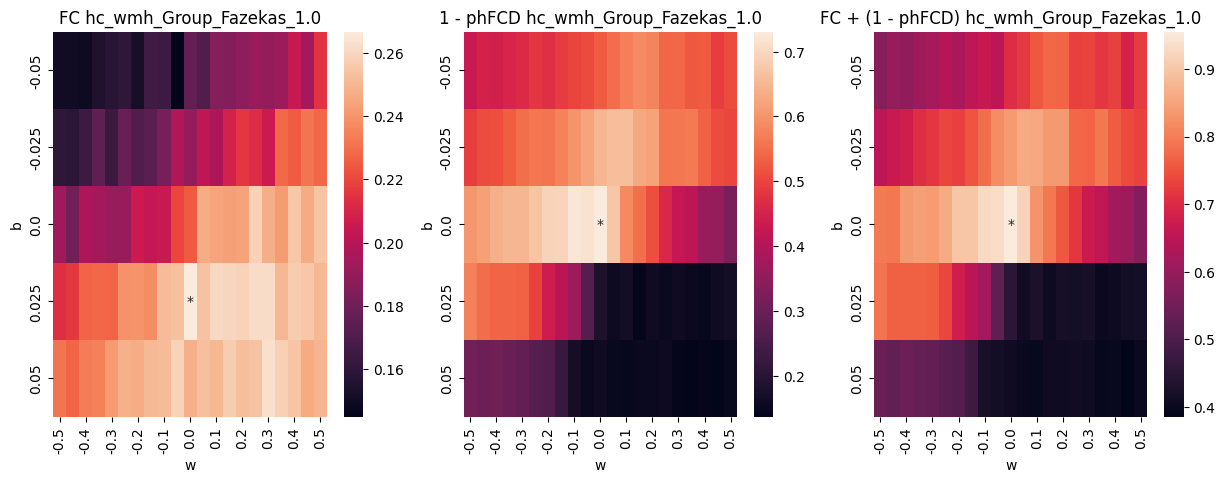

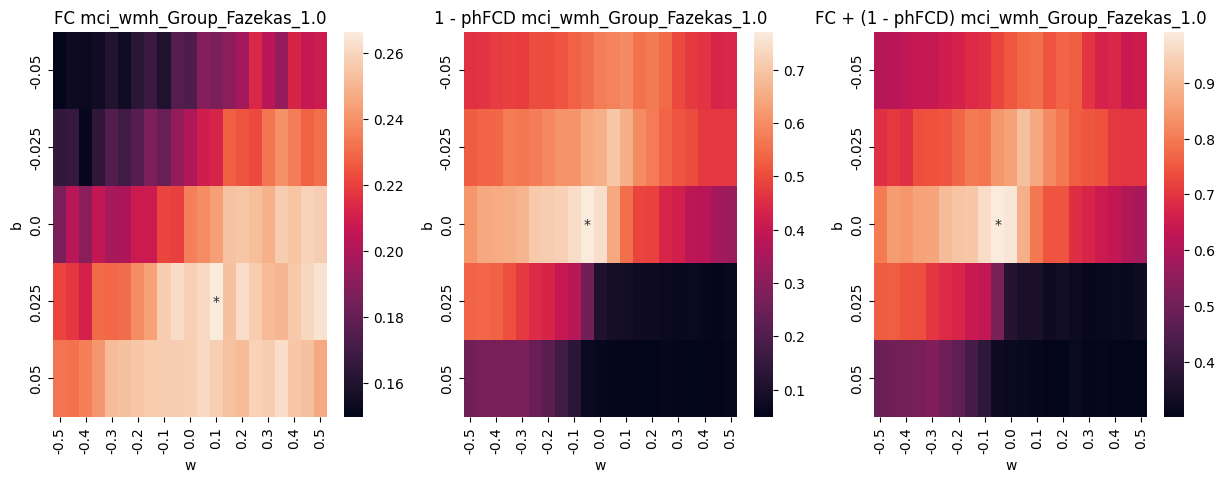

In [11]:
perform_group_analyses(adnimerge, big_df, 'Group_Fazekas_1.0')

In [13]:
fzk1_best_fit_b_hc = 0.0
fzk1_best_fit_w_hc = 0.0
fzk1_best_fit_b_mci = 0.0
fzk1_best_fit_w_mci = -0.05

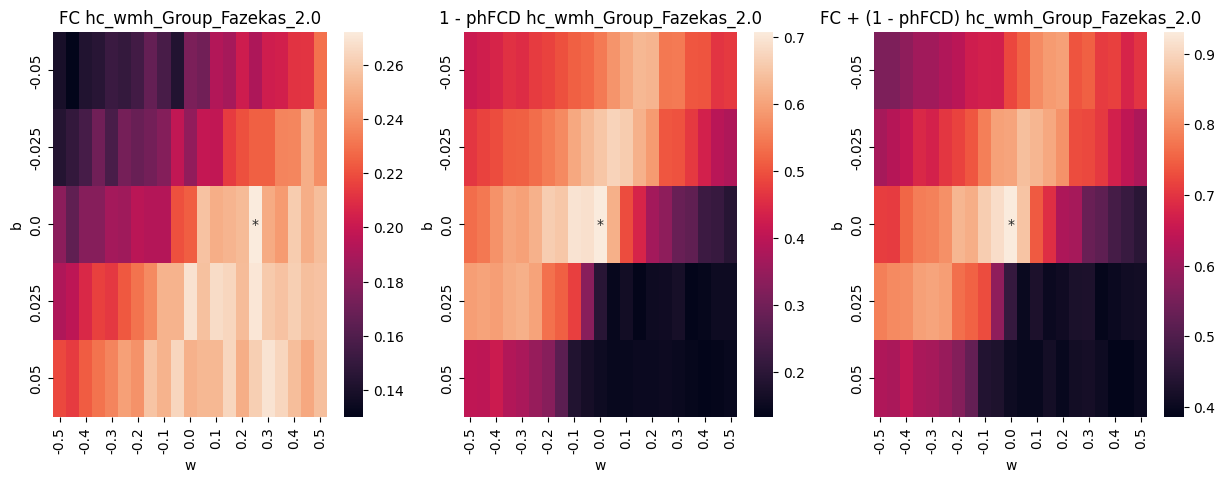

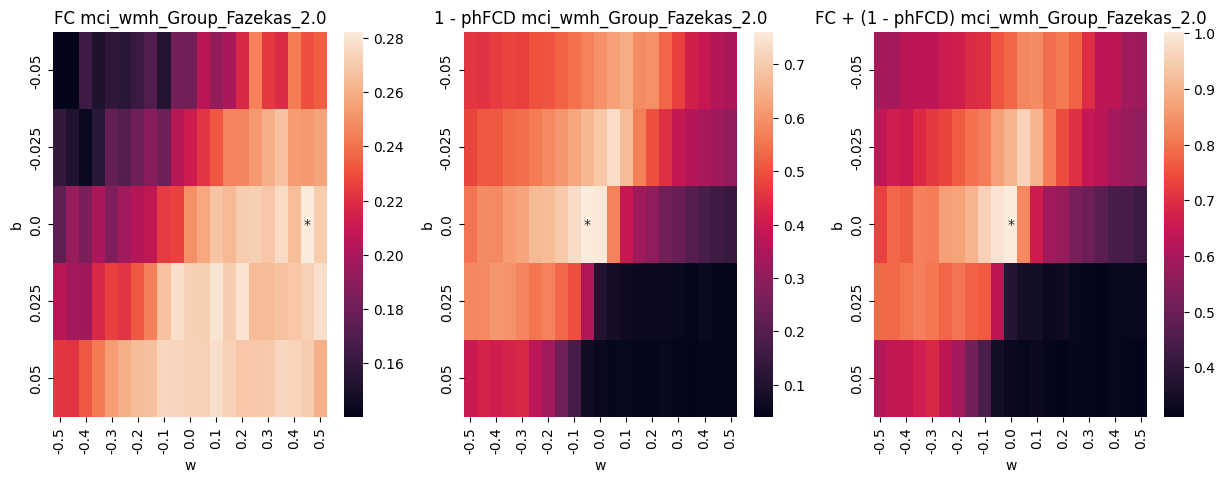

In [14]:
perform_group_analyses(adnimerge, big_df, 'Group_Fazekas_2.0')

In [16]:
fzk2_best_fit_b_hc = 0.0
fzk2_best_fit_w_hc = 0.0
fzk2_best_fit_b_mci = 0.0
fzk2_best_fit_w_mci = -0.05

In [ ]:
# df_boxplot = big_df[(big_df['b'] == 0.1) | (big_df['b'] == 0.1)]
# df_boxplot = pd.merge(df_boxplot, adnimerge[['PTID','Group_Fazekas_2.0', 'Group_Fazekas_1.0']], on = 'PTID')
# df_boxplot_long = pd.melt(df_boxplot, id_vars=['PTID', 'w', 'fc_pearson', 'phfcd_ks'], value_vars=['Group_Fazekas_2.0', 'Group_Fazekas_1.0'], var_name='group', value_name='values')
# df_boxplot_long['group_values'] = df_boxplot_long['group'] + '_' + df_boxplot_long['values']
# #only show subjects with WMH
# dummy_cat = pd.CategoricalDtype(['CN_WMH', 'MCI_WMH'])
# order = [cat for cat in dummy_cat.categories if df_boxplot_long['values'].str.contains(cat).any()]
# n=2
# fig, axs = plt.subplots(n, 2, figsize = (10, 10))
# for i, w in enumerate(df_boxplot_long['w'].unique()[:n]):
#     w_df = df_boxplot_long[df_boxplot_long['w'] == w]
#     sns.boxplot(ax = axs[i][0],
#                 data = w_df, 
#                 x = 'values', 
#                 y = 'fc_pearson', 
#                 hue = 'group', 
#                 order=order)
#     sns.boxplot(ax = axs[i][1],
#                 data = w_df, 
#                 x = 'values', 
#                 y = 'phfcd_ks', 
#                 hue = 'group', 
#                 order=order)

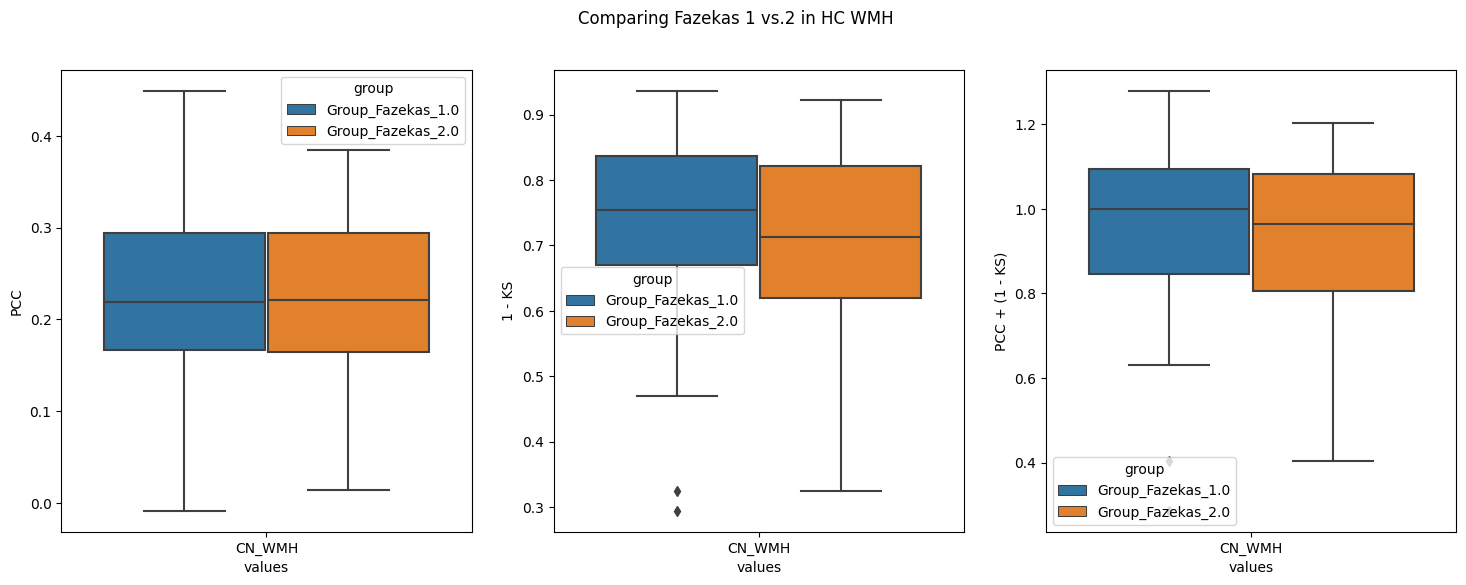

In [17]:
# Create a smaller dataset selecting only the best
df_boxplot = big_df[(big_df['b'] == fzk1_best_fit_b_hc) | (big_df['b'] == fzk2_best_fit_b_hc) | (big_df['b'] == fzk1_best_fit_b_mci) | (big_df['b'] == fzk2_best_fit_b_mci) | (big_df['b'] == 0)]
# Merge this database with just the column of interest
df_boxplot = pd.merge(df_boxplot, adnimerge[['PTID','Group_Fazekas_2.0', 'Group_Fazekas_1.0']], on = 'PTID')
# Pivot to long
df_boxplot_long = pd.melt(df_boxplot, id_vars=['PTID', 'w', 'b', 'fc_pearson', 'phfcd_ks'], value_vars=['Group_Fazekas_2.0', 'Group_Fazekas_1.0'], var_name='group', value_name='values')
df_boxplot_long['group_values'] = df_boxplot_long['group'] + '_' + df_boxplot_long['values']
df_boxplot_long['summed_fc_phfcd'] = df_boxplot_long['fc_pearson'] + df_boxplot_long['phfcd_ks']

#Helpful to only show the categories we want to show in the boxplot and not those without WMH
dummy_cat = pd.CategoricalDtype(['CN_WMH'])
order = [cat for cat in dummy_cat.categories if df_boxplot_long['values'].str.contains(cat).any()]

# Idk why if I use fzk1_best_fit_w_hc is not working.. so for now insert manually
compare_df_hc_1 = df_boxplot_long[(df_boxplot_long['w'] == fzk1_best_fit_w_hc) & (df_boxplot_long['b'] == fzk1_best_fit_b_hc)]
compare_df_hc_1 = compare_df_hc_1[compare_df_hc_1['group'] == 'Group_Fazekas_1.0']
compare_df_hc_2 = df_boxplot_long[(df_boxplot_long['w'] == fzk2_best_fit_w_hc) & (df_boxplot_long['b'] == fzk2_best_fit_b_hc)]
compare_df_hc_2 = compare_df_hc_2[compare_df_hc_2['group'] == 'Group_Fazekas_2.0']
joined_compare_df_hc = pd.concat([compare_df_hc_1, compare_df_hc_2])

fig, axs = plt.subplots(1,3, figsize = (18, 6))
sns.boxplot(ax = axs[0],
            data = joined_compare_df_hc, 
            x = 'values', 
            y = 'fc_pearson', 
            hue = 'group', 
            order=order)
axs[0].set_ylabel('PCC')
sns.boxplot(ax = axs[1],
            data = joined_compare_df_hc, 
            x = 'values', 
            y = 'phfcd_ks', 
            hue = 'group', 
            order=order)
axs[1].set_ylabel('1 - KS')
sns.boxplot(ax = axs[2],
            data = joined_compare_df_hc, 
            x = 'values', 
            y = 'summed_fc_phfcd', 
            hue = 'group', 
            order=order)
axs[2].set_ylabel('PCC + (1 - KS)')
fig.suptitle('Comparing Fazekas 1 vs.2 in HC WMH')
plt.savefig(EXPL_FIG_DIR / "compare_best_b_w_among_groupings_hc_wmh.png")

array([-0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
        0.08,  0.09,  0.1 ])

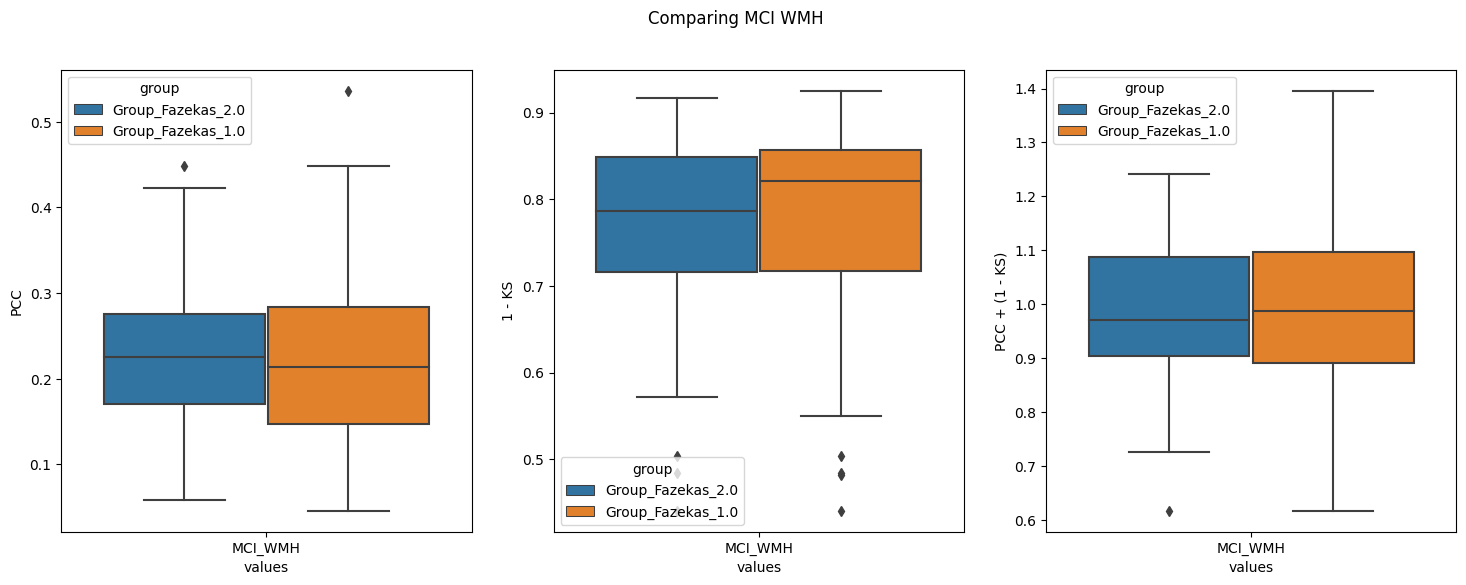

In [20]:

compare_df_mci_1 = df_boxplot_long[(df_boxplot_long['w'] == -0.05) & (df_boxplot_long['b'] == fzk1_best_fit_b_mci)]
compare_df_mci_1 = compare_df_mci_1[compare_df_mci_1['group'] == 'Group_Fazekas_1.0']
compare_df_mci_2 = df_boxplot_long[(df_boxplot_long['w'] == -0.05) & (df_boxplot_long['b'] == fzk2_best_fit_b_mci)]
compare_df_mci_2 = compare_df_mci_2[compare_df_mci_2['group'] == 'Group_Fazekas_2.0']
joined_compare_df = pd.concat([compare_df_mci_2, compare_df_mci_1])
dummy_cat = pd.CategoricalDtype(['MCI_WMH'])
order = [cat for cat in dummy_cat.categories if df_boxplot_long['values'].str.contains(cat).any()]

fig, axs = plt.subplots(1,3, figsize = (18, 6))
sns.boxplot(ax = axs[0],
            data = joined_compare_df, 
            x = 'values', 
            y = 'fc_pearson', 
            hue = 'group', 
            order=order)
axs[0].set_ylabel('PCC')
sns.boxplot(ax = axs[1],
            data = joined_compare_df, 
            x = 'values', 
            y = 'phfcd_ks', 
            hue = 'group', 
            order=order)
axs[1].set_ylabel('1 - KS')
sns.boxplot(ax = axs[2],
            data = joined_compare_df, 
            x = 'values', 
            y = 'summed_fc_phfcd', 
            hue = 'group', 
            order=order)
axs[2].set_ylabel('PCC + (1 - KS)')
fig.suptitle('Comparing MCI WMH')
plt.savefig(EXPL_FIG_DIR / "compare_best_b_w_among_groupings_mci_wmh.png")

C:\Users\local_leoner\Temp\13\ipykernel_12508\113982359.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_df_hc_baseline['group'] = compare_df_hc_baseline['group'].replace('Group_Fazekas_2.0', 'baseline')


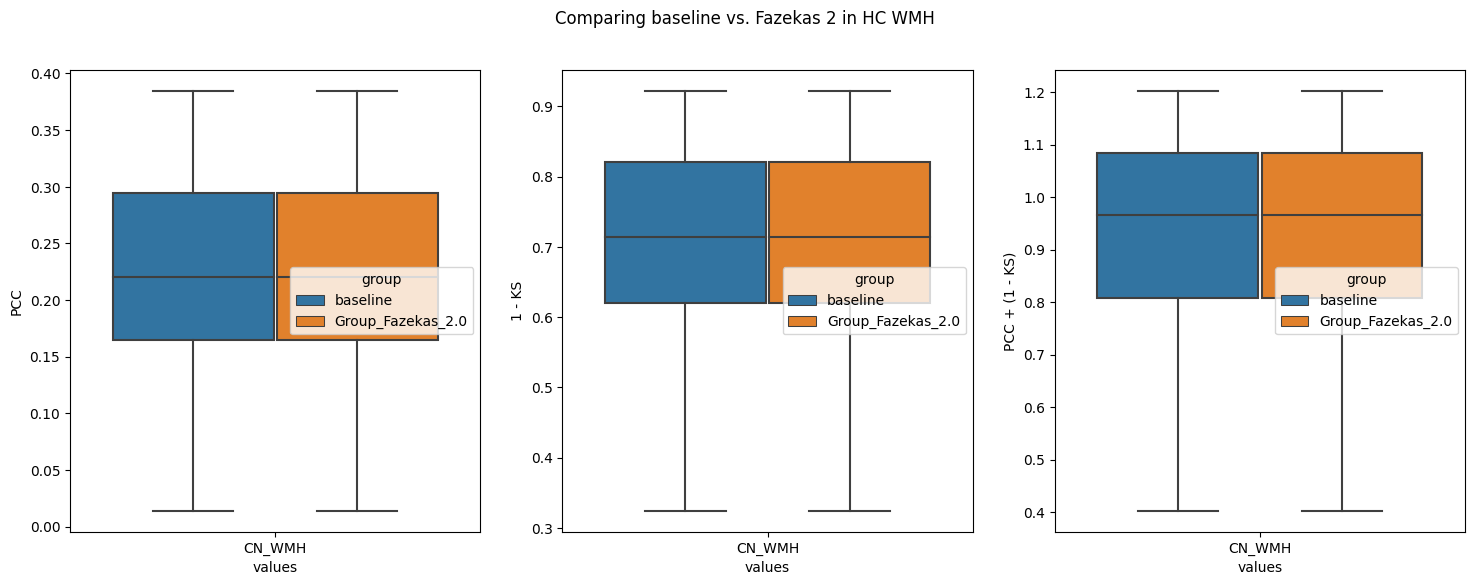

In [21]:
#The homogeneous model with b = 0 and w = 0 is the same as applying the best found model in the HC no WMH group since if b and w = 0, then:
# a = -0.02 + 0 * WMH + 0 = -0.02
# So we use this as a baseline for comparison.
compare_df_hc_baseline = df_boxplot_long[(df_boxplot_long['w'] == 0.0) & (df_boxplot_long['b'] == 0.0)]
compare_df_hc_baseline['group'] = compare_df_hc_baseline['group'].replace('Group_Fazekas_2.0', 'baseline')
compare_df_hc_baseline = compare_df_hc_baseline[compare_df_hc_baseline['group'] == 'baseline']
joined_compare_df_hc = pd.concat([compare_df_hc_baseline, compare_df_hc_2])

#Helpful to only show the categories we want to show in the boxplot and not those without WMH
dummy_cat = pd.CategoricalDtype(['CN_WMH'])
order = [cat for cat in dummy_cat.categories if df_boxplot_long['values'].str.contains(cat).any()]

fig, axs = plt.subplots(1,3, figsize = (18, 6))
sns.boxplot(ax = axs[0],
            data = joined_compare_df_hc, 
            x = 'values', 
            y = 'fc_pearson', 
            hue = 'group', 
            order=order)
axs[0].set_ylabel('PCC')
sns.boxplot(ax = axs[1],
            data = joined_compare_df_hc, 
            x = 'values', 
            y = 'phfcd_ks', 
            hue = 'group', 
            order=order)
axs[1].set_ylabel('1 - KS')
sns.boxplot(ax = axs[2],
            data = joined_compare_df_hc, 
            x = 'values', 
            y = 'summed_fc_phfcd', 
            hue = 'group', 
            order=order)
axs[2].set_ylabel('PCC + (1 - KS)')
fig.suptitle('Comparing baseline vs. Fazekas 2 in HC WMH')
plt.savefig(EXPL_FIG_DIR / "compare_baseline_with_best_b_w_among_groupings_hc_wmh.png")

C:\Users\local_leoner\Temp\13\ipykernel_12508\650784978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_df_mci_baseline['group'] = compare_df_mci_baseline['group'].replace('Group_Fazekas_2.0', 'baseline')


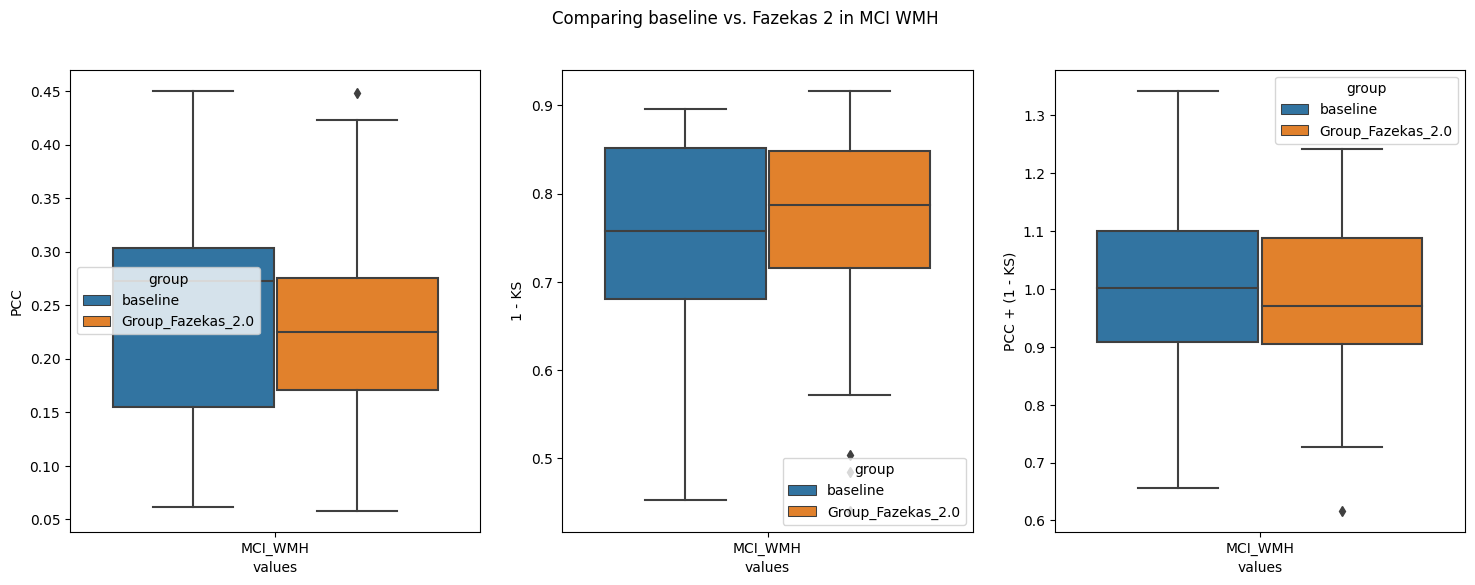

In [24]:
compare_df_mci_baseline = df_boxplot_long[(df_boxplot_long['w'] == 0) & (df_boxplot_long['b'] == 0)]
compare_df_mci_baseline['group'] = compare_df_mci_baseline['group'].replace('Group_Fazekas_2.0', 'baseline')
compare_df_mci_baseline = compare_df_mci_baseline[compare_df_mci_baseline['group'] == 'baseline']
joined_compare_df_mci = pd.concat([compare_df_mci_baseline, compare_df_mci_2])

dummy_cat = pd.CategoricalDtype(['MCI_WMH'])
order = [cat for cat in dummy_cat.categories if df_boxplot_long['values'].str.contains(cat).any()]

fig, axs = plt.subplots(1,3, figsize = (18, 6))
sns.boxplot(ax = axs[0],
            data = joined_compare_df_mci, 
            x = 'values', 
            y = 'fc_pearson', 
            hue = 'group', 
            order=order)
axs[0].set_ylabel('PCC')
sns.boxplot(ax = axs[1],
            data = joined_compare_df_mci, 
            x = 'values', 
            y = 'phfcd_ks', 
            hue = 'group', 
            order=order)
axs[1].set_ylabel('1 - KS')
sns.boxplot(ax = axs[2],
            data = joined_compare_df_mci, 
            x = 'values', 
            y = 'summed_fc_phfcd', 
            hue = 'group', 
            order=order)
axs[2].set_ylabel('PCC + (1 - KS)')
fig.suptitle('Comparing baseline vs. Fazekas 2 in MCI WMH')
plt.savefig(EXPL_FIG_DIR / "compare_baseline_with_best_b_w_among_groupings_mci_wmh.png")

Text(0.5, 0.98, 'Summary of best model fits for MCI no WMH')

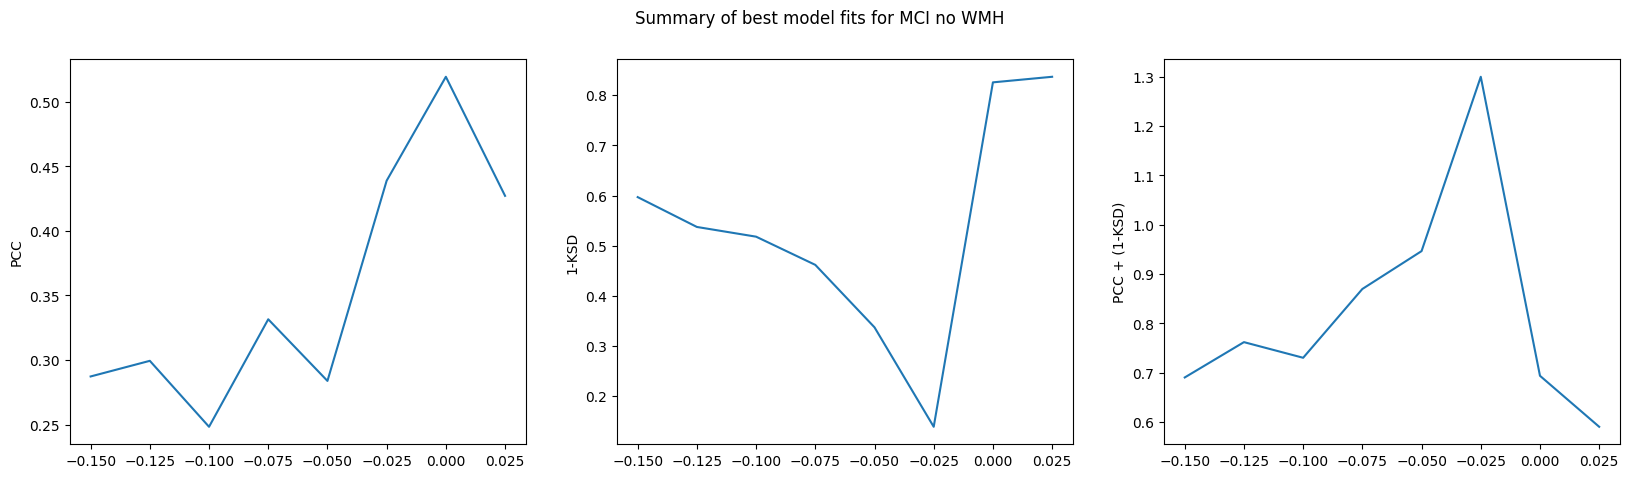

In [25]:
df_mci_noWMH = pd.read_csv(RES_DIR / "model_simulations" / "MCI_noWMH" / "MCI_df_results_initial_exploration_wmh.csv", index_col=0)
df_mci_noWMH['fc_phfcd'] = df_mci_noWMH['fc_pearson'] + (1 - df_mci_noWMH['phfcd_ks'])

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(df_mci_noWMH['a'], df_mci_noWMH['fc_pearson'])
plt.ylabel('PCC')
plt.subplot(132)
plt.plot(df_mci_noWMH['a'], df_mci_noWMH['phfcd_ks'])
plt.ylabel('1-KSD')
plt.subplot(133)
plt.plot(df_mci_noWMH['a'], df_mci_noWMH['fc_phfcd'])
plt.ylabel('PCC + (1-KSD)')
plt.suptitle(f"Summary of best model fits for MCI no WMH")


Now the elephant in the room, since the best fitting are at more positive values of a_s...

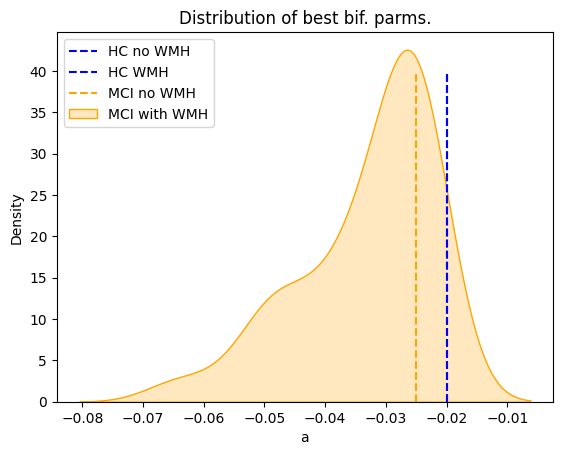

In [39]:
# Now get the a 
wmh_HC_WMH = np.array([wmh_dict[subj] for subj in short_subjs if subj in HC_WMH])
wmh_MCI_WMH = np.array([wmh_dict[subj] for subj in short_subjs if subj in MCI_WMH])

#as_HC_WMH = -0.02 + wmh_HC_WMH * fzk2_best_fit_w_hc + fzk2_best_fit_b_hc
# same problem as before, using fzk2_best_fit_w_mci doesn't work for some reasons
as_MCI_WMH = -0.02 + wmh_HC_WMH * fzk2_best_fit_w_mci + fzk2_best_fit_b_mci
plt.vlines(-0.02, 0, 40, color = 'blue', linestyles='--', label = 'HC no WMH')
plt.vlines(-0.02, 0, 40, color = 'blue', linestyles='--', label = 'HC WMH')
plt.vlines(-0.025, 0, 40, color = 'orange', linestyles='--', label = 'MCI no WMH')
# sns.kdeplot(as_HC_WMH, label = 'HC with WMH', )
sns.kdeplot(as_MCI_WMH, label = 'MCI with WMH', color = 'orange', fill = True)
plt.xlabel('a')
plt.title('Distribution of best bif. parms.')
plt.legend(loc = 'upper left')